# Course 3 Final Project: Predicting Soccer Outcomes

---

In this report, I am going to load in a data set with information regarding soccer games played in the Premier League during the 2020-2021 season, and I am going to create a model taking in the features of the dataset to determine the outcome of the game for the home team. Since during this time the COVID-19 pandemic occurred, we will have to adjust some values. The data set has the following columns:
- date: the date of the game
- time: the time of the game
- comp: the competition of the game
- round: the round of the game
- day: the day of the week of the game
- venue: the venue of the game
- result: the result of the game
- gf: the goals for the home team
- ga: the goals for the away team
- opponent: the opponent of the home team
- xg: the expected goals for the home team
- xga: the expected goals for the away team
- poss: the possession of the home team
- captain: the captain of the home team
- formation: the formation of the home team
- referee: the referee of the game
- sh: the shots of the home team
- sot: the shots on target of the home team
- dist: the average distance of the shots of the home team
- fk: the free kicks of the home team
- pk: the penalty kicks of the home team
- pkatt: the penalty kicks attempted of the home team
- season: the season year of the match
- team: the home team

---

# Importing Necessary Libraries

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore") 

---

# About the Data:

In [68]:
df = pd.read_csv("data.csv")
pl_df = df.copy()
pl_df.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2020-09-21,20:15 (21:15),Premier League,Matchweek 2,Mon,Away,W,3,1,...,Match Report,NaN,13,8,21.1,2,1,1,2024,Manchester City
1,2,2020-09-27,16:30 (17:30),Premier League,Matchweek 3,Sun,Home,L,2,5,...,Match Report,NaN,16,5,19.8,1,0,0,2024,Manchester City
2,4,2020-10-03,17:30 (18:30),Premier League,Matchweek 4,Sat,Away,D,1,1,...,Match Report,NaN,23,1,18.2,1,0,0,2024,Manchester City
3,5,2020-10-17,17:30 (18:30),Premier League,Matchweek 5,Sat,Home,W,1,0,...,Match Report,NaN,13,5,17.7,0,0,0,2024,Manchester City
4,7,2020-10-24,12:30 (13:30),Premier League,Matchweek 6,Sat,Away,D,1,1,...,Match Report,NaN,14,7,20.9,1,0,0,2024,Manchester City


Let's check to see how many null values, the shape, and general information about the dataset:

In [69]:
print("Shape of the dataset:",pl_df.shape)
print("\nNumber of nulls:",pl_df.isnull().sum().sum())
print("\nNumber of duplicate rows:",pl_df.duplicated().sum())
print("\nThe amount of each data type:\n",pl_df.dtypes.value_counts())

Shape of the dataset: (4788, 28)

Number of nulls: 6423

Number of duplicate rows: 0

The amount of each data type:
 object     13
int64      10
float64     5
Name: count, dtype: int64


Finally, let's look at the distribution of the outcomes of the matches. As we can see, the distribution is slightly unbalanced in terms of draws. We will fix that in the preprocessing step.

In [70]:
pl_df['result'].value_counts(normalize=True)

result
W    0.395781
L    0.380117
D    0.224102
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribution of Results'}, xlabel='Result', ylabel='Frequency'>

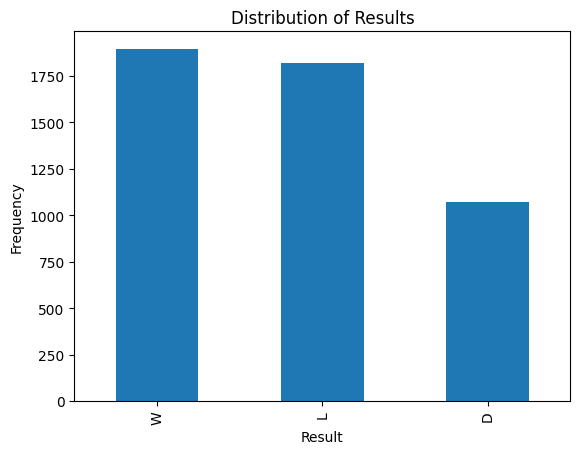

In [71]:
pl_df['result'].value_counts().plot.bar(xlabel='Result', ylabel='Frequency', title='Distribution of Results')

---

# Manipulation

We can see that the `notes` column contains only null values. Also, the `attendance` column has some null values, probably due to COVID-19. Even though that would be an interesting feature to play with, we are going to drop the column since a fourth of the values are null. In the future, we could play with the data set that does not contain those values, but contains the whole feature of attendance. Lastly, `dist` has 2 null values. Let's drop those occurences.

In [72]:
pl_df.isnull().sum()

Unnamed: 0         0
date               0
time               0
comp               0
round              0
day                0
venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
attendance      1633
captain            0
formation          0
referee            0
match report       0
notes           4788
sh                 0
sot                0
dist               2
fk                 0
pk                 0
pkatt              0
season             0
team               0
dtype: int64

In [73]:
pl_df.drop(columns=['notes', 'attendance', df.columns[0]], inplace=True)

In [74]:
pl_df.drop(index=pl_df[pl_df['dist'].isnull()].index, inplace=True)

In [75]:
print(pl_df.isnull().sum())
print("\nShape of new dataset: ", pl_df.shape)
print("Shape of old dataset: ", df.shape)

date            0
time            0
comp            0
round           0
day             0
venue           0
result          0
gf              0
ga              0
opponent        0
xg              0
xga             0
poss            0
captain         0
formation       0
referee         0
match report    0
sh              0
sot             0
dist            0
fk              0
pk              0
pkatt           0
season          0
team            0
dtype: int64

Shape of new dataset:  (4786, 25)
Shape of old dataset:  (4788, 28)


Looking into the data, we want to remove repeated rows. If we include all the features, there are no repeated rows, however, if we look at all the features except season, we can see we have duplicates. We can remove these rows since we are just predicting wins or losses. If we were predicting wins or losses for specific teams, we would need to leave them in as they would add weight. For the general aspect of winning, losing, or drawing, we can remove these duplicates.

In [76]:
cols = pl_df.columns
cols = cols.drop('season')
print("There are {} duplicated rows when the season column is removed.\n".format(pl_df.duplicated(subset=cols).sum()))
print("Dropping the duplicates:")
before_drop = pl_df.shape[0]
print("The total amount of rows before dropping: {}".format(before_drop))

pl_df.drop_duplicates(subset=cols, inplace=True)
print("There are {} duplicated rows when the season column is removed.".format(pl_df.duplicated(subset=cols).sum()))
print("The total amount of rows after dropping: {}".format(pl_df.shape[0]))
print(f"\nThe difference between the two: {before_drop - pl_df.shape[0]}")

There are 987 duplicated rows when the season column is removed.

Dropping the duplicates:
The total amount of rows before dropping: 4786
There are 0 duplicated rows when the season column is removed.
The total amount of rows after dropping: 3799

The difference between the two: 987


After cleaning up that part of the data set, let us make add a new feature for the dataset to help out our modeling!

In [77]:
# Shot on target precentage for the home team
pl_df['sot_perc'] = pl_df['sot'] / pl_df['sh']

----

# Preprocessing for Model

Firstly, what we need to do is obtain the features we are going to use to try and predict the match outcome. Then, we need to use encoding techniques for features that are not integer/floats.

The features that we are going to select are:
- gf: goals for the home team
- ga: goals for the away team
- xg: expected goals for the home team
- xga: expected goals for the away team
- poss: the possession of the home team
- sot_perc: the precentage of shots on target for the home team
- goal_perc: The goal percentage for the home team
- dist: the average distance of the shots of the home team
- fk: the free kicks of the home team
- pk: the penalty kicks of the home team
- pkatt: the penalty kicks attempted of the home team
- result: the result of the game

`Note:` the result of the game is in terms of the Home team. If the result is 'W', then the home team won. If the result is 'L', then the home team lost (away team won). Finally, if the result is 'D', then the home and away team had a draw.

In [78]:
columns = ['xg','xga','poss', 'sot_perc', 'dist', 'fk', 'pk', 'pkatt', 'result']

In [79]:
new_df = pl_df[columns]
new_df.head()

,xg,xga,poss,sot_perc,dist,fk,pk,pkatt,result
0,1.9,0.6,65,0.615385,21.1,2,1,1,W
1,0.9,2.9,72,0.312500,19.8,1,0,0,L
2,1.2,2.4,49,0.043478,18.2,1,0,0,D
3,1.3,0.9,58,0.384615,17.7,0,0,0,W
4,1.0,0.3,69,0.500000,20.9,1,0,0,D


Now, let's use label encoding for the results column:

In [80]:
le = LabelEncoder()
new_df.loc[:,'result'] = le.fit_transform(new_df['result'])

In [81]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("The mapping from the results to numeric values:", mapping)

The mapping from the results to numeric values: {'D': 0, 'L': 1, 'W': 2}


Now, let's get out X and y, and then run a train_test_split

In [82]:
X = new_df.iloc[:,:-1]
y = new_df.result

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [84]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [85]:
# Creating a balanced set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [86]:
y_train.value_counts(normalize=True)

result
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribution of Results after SMOTE'}, xlabel='Result', ylabel='Frequency'>

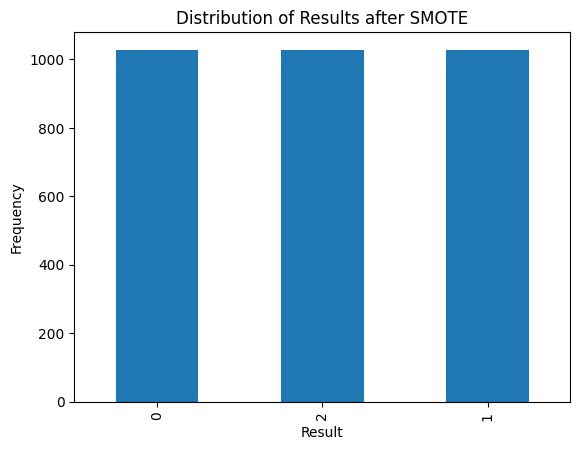

In [87]:
y_train.value_counts().plot.bar(xlabel='Result', ylabel='Frequency', title='Distribution of Results after SMOTE')

---

# Models

## Logistic Regression

Let's look at the LogisticRegression model:

In [88]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.33      0.42      0.37       259
           1       0.67      0.64      0.66       440
           2       0.69      0.61      0.65       441

    accuracy                           0.58      1140
   macro avg       0.57      0.56      0.56      1140
weighted avg       0.60      0.58      0.59      1140



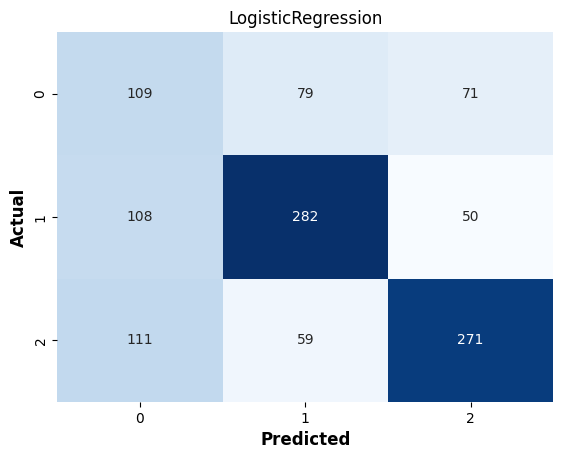

In [89]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('LogisticRegression')
plt.show()

Let's use GridSearchCV to find the best parameters!

In [90]:
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.1,0.5,1,2,3,4,5,10],
    'solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

search = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, scoring = 'f1', cv = 5)
search.fit(X_train,y_train)
print(search.best_params_)
y_pred_lr2 = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_lr2))

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.31      0.29      0.30       259
           1       0.65      0.67      0.66       440
           2       0.67      0.68      0.67       441

    accuracy                           0.59      1140
   macro avg       0.54      0.55      0.54      1140
weighted avg       0.58      0.59      0.58      1140



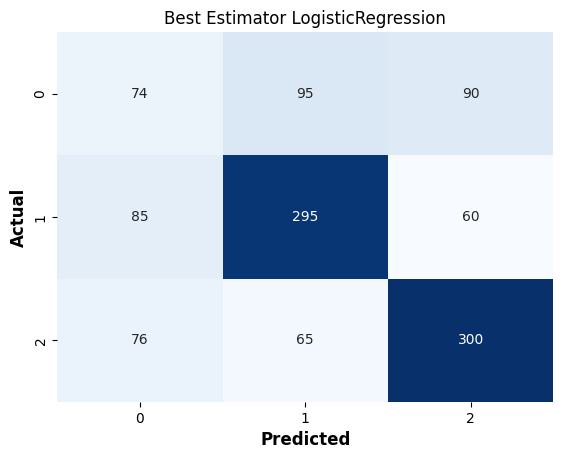

In [91]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr2), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimator LogisticRegression')
plt.show()

As we can see, for predicting a draw, the recall and f1-score are EXTREMELY low. The precision as well is abnormally low. LogisticRegression might not the be most beneficial model to use. Let's look at other models.

## KNearestNeighbors

Here, we first are going to start with KNearestNeighbors:

In [92]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN = KNN.fit(X_train, y_train)
y_pred_KNN = KNN.predict(X_test)
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       0.24      0.42      0.31       259
           1       0.56      0.47      0.51       440
           2       0.57      0.41      0.48       441

    accuracy                           0.44      1140
   macro avg       0.46      0.43      0.43      1140
weighted avg       0.49      0.44      0.45      1140



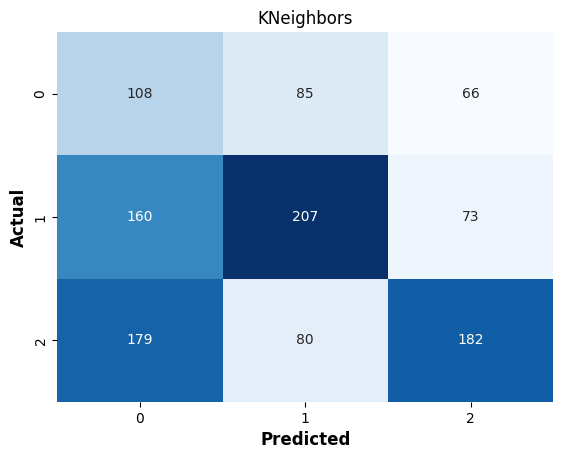

In [93]:
sns.heatmap(confusion_matrix(y_test, y_pred_KNN), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('KNeighbors')
plt.show()

Let's use GridSearchCV and cross-validation in order to find the best parameters for our KNN Model

In [94]:
param_grid = {
    'n_neighbors': [1,2,3,4,5,10,15,20,25],
    'weights': ['uniform', 'distance']
}

search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, scoring = 'f1', cv = 5)
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20, 25],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [95]:
search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [96]:
y_pred_KNN2 = search.best_estimator_.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred_KNN2))

              precision    recall  f1-score   support

           0       0.26      0.30      0.28       259
           1       0.49      0.52      0.51       440
           2       0.52      0.45      0.48       441

    accuracy                           0.44      1140
   macro avg       0.43      0.42      0.42      1140
weighted avg       0.45      0.44      0.45      1140



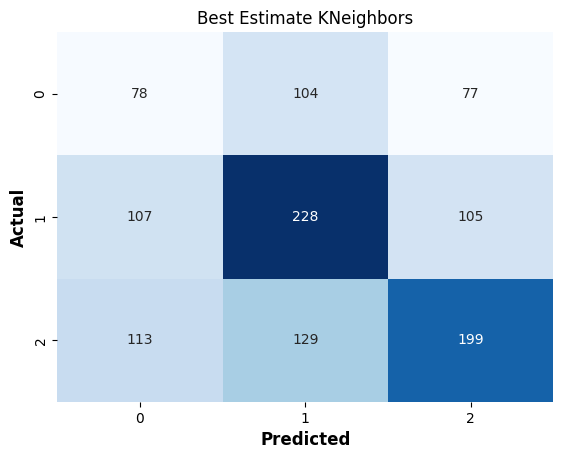

In [98]:
sns.heatmap(confusion_matrix(y_test, y_pred_KNN2), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimate KNeighbors')
plt.show()

As we can see, when looking at the best accuracy between all variant of hyperparameters, we get the best model when `n_neighbors` is 15. When looking at the precision, recall, and fscore, we see that for class `0` (which is draw), our model is not the best. However, looking at those values when predicting winning or losing, our model does fairly well. 

## Support Vector Machines

Since we have few features (< 100 features) and more than 1,000 rows, we should used SVC with RBF 

In [99]:
rbfSVC = SVC(kernel='rbf', gamma=1.0, C=10.0)
rbfSVC = rbfSVC.fit(X_train, y_train)
y_pred_SVC = rbfSVC.predict(X_test)

print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.29      0.24      0.26       259
           1       0.51      0.53      0.52       440
           2       0.51      0.54      0.53       441

    accuracy                           0.47      1140
   macro avg       0.44      0.44      0.44      1140
weighted avg       0.46      0.47      0.47      1140



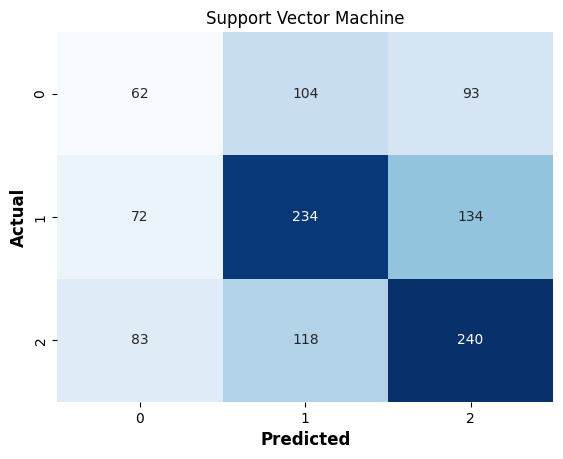

In [100]:
sns.heatmap(confusion_matrix(y_test, y_pred_SVC), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Support Vector Machine')
plt.show()

Tuning our parameters...

In [101]:
param_grid = {
    'C': [0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,10,100],
    'kernel': ['rbf','poly','sigmoid']
}

model = SVC()
grid_search = GridSearchCV(estimator = model, 
                           param_grid = param_grid, 
                           scoring='f1',
                           cv = 5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'C': 0.1, 'kernel': 'rbf'}

In [102]:
y_pred_SVC2 = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_SVC2))

              precision    recall  f1-score   support

           0       0.18      0.02      0.03       259
           1       0.44      0.54      0.48       440
           2       0.44      0.57      0.50       441

    accuracy                           0.43      1140
   macro avg       0.35      0.38      0.34      1140
weighted avg       0.38      0.43      0.39      1140



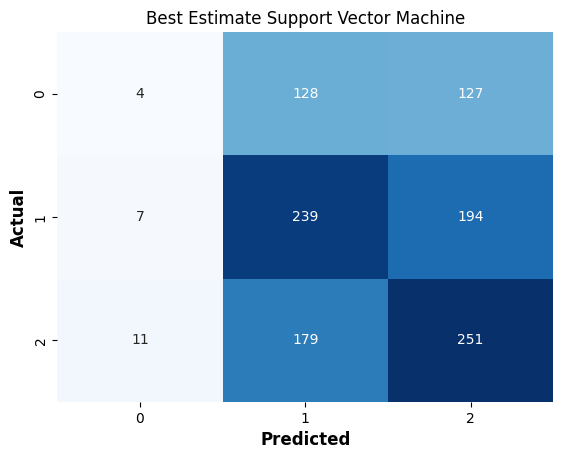

In [103]:
sns.heatmap(confusion_matrix(y_test, y_pred_SVC2), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimate Support Vector Machine')
plt.show()

## Decision Trees

In this section, we will run decision tree models (RandomForest, Extra Random Trees, and Bagging for a Decision Tree)

### RandomForest

In [104]:
RF = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
RF = RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.31      0.29      0.30       259
           1       0.64      0.68      0.66       440
           2       0.68      0.66      0.67       441

    accuracy                           0.58      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.58      0.58      0.58      1140



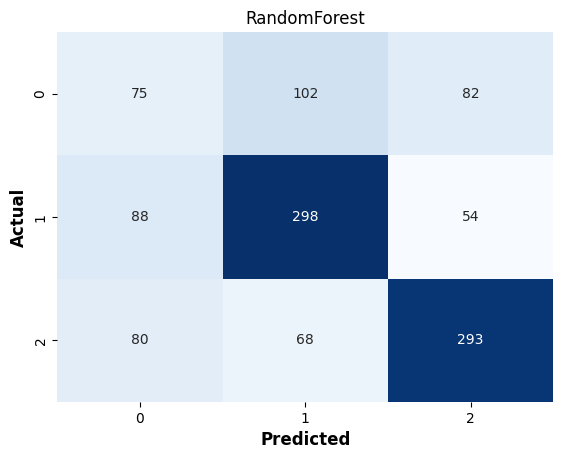

In [105]:
sns.heatmap(confusion_matrix(y_test, y_pred_RF), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('RandomForest')
plt.show()

In [126]:
param_grid = {
    'n_estimators': [1,5,10,50,100,200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1,2,3,4,5,10]
}

search = GridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, scoring='accuracy', cv = 5)
search.fit(X_train, y_train)
search.best_params_

{'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 200}

In [127]:
y_pred_RF2 = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_RF2))

              precision    recall  f1-score   support

           0       0.34      0.37      0.35       259
           1       0.67      0.66      0.67       440
           2       0.69      0.66      0.67       441

    accuracy                           0.59      1140
   macro avg       0.57      0.56      0.56      1140
weighted avg       0.60      0.59      0.60      1140



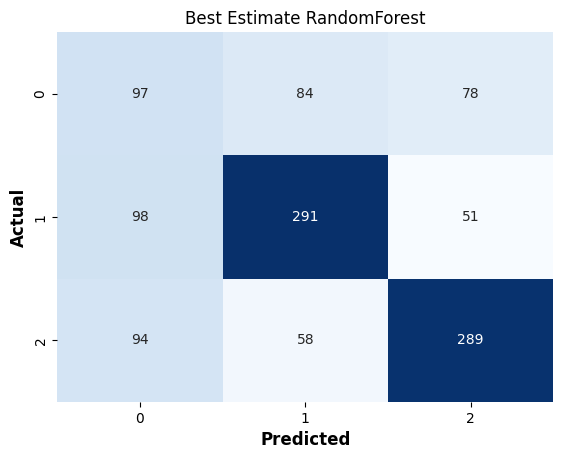

In [128]:
sns.heatmap(confusion_matrix(y_test, y_pred_RF2), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimate RandomForest')
plt.show()

### Extra Random Trees

In [124]:
ETC = ExtraTreesClassifier(n_estimators = 100, criterion = 'gini')
ETC = ETC.fit(X_train, y_train)
y_pred_ETC = ETC.predict(X_test)
print(classification_report(y_test, y_pred_ETC))

              precision    recall  f1-score   support

           0       0.29      0.26      0.28       259
           1       0.63      0.66      0.65       440
           2       0.65      0.66      0.66       441

    accuracy                           0.57      1140
   macro avg       0.53      0.53      0.53      1140
weighted avg       0.56      0.57      0.57      1140



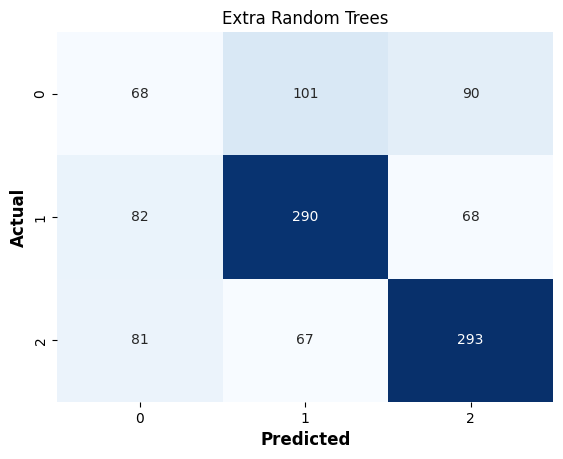

In [125]:
sns.heatmap(confusion_matrix(y_test, y_pred_ETC), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Extra Random Trees')
plt.show()

In [129]:
param_grid = {
    'n_estimators': [1,5,10,50,100,200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1,2,3,4,5,10]
}
search = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid = param_grid, scoring='accuracy', cv = 5)
search.fit(X_train, y_train)
search.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}

In [130]:
y_pred_ETC2 = search.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred_ETC2))

              precision    recall  f1-score   support

           0       0.33      0.35      0.34       259
           1       0.67      0.67      0.67       440
           2       0.68      0.64      0.66       441

    accuracy                           0.59      1140
   macro avg       0.56      0.55      0.56      1140
weighted avg       0.59      0.59      0.59      1140



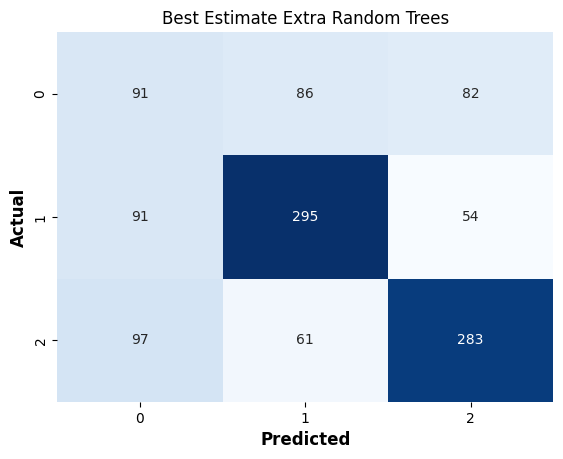

In [131]:
sns.heatmap(confusion_matrix(y_test, y_pred_ETC2), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimate Extra Random Trees')
plt.show()

## Bagging

In [135]:
Bag = BaggingClassifier(estimator = DecisionTreeClassifier(), bootstrap = True)
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
     'estimator__max_depth' : [2*n+1 for n in range(10) ] }

search = GridSearchCV(estimator = Bag, param_grid = param_grid, cv = 5, scoring = 'accuracy')
search.fit(X_train, y_train)

y_pred_bag = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_bag))

              precision    recall  f1-score   support

           0       0.30      0.33      0.31       259
           1       0.61      0.63      0.62       440
           2       0.67      0.61      0.64       441

    accuracy                           0.56      1140
   macro avg       0.53      0.52      0.53      1140
weighted avg       0.56      0.56      0.56      1140



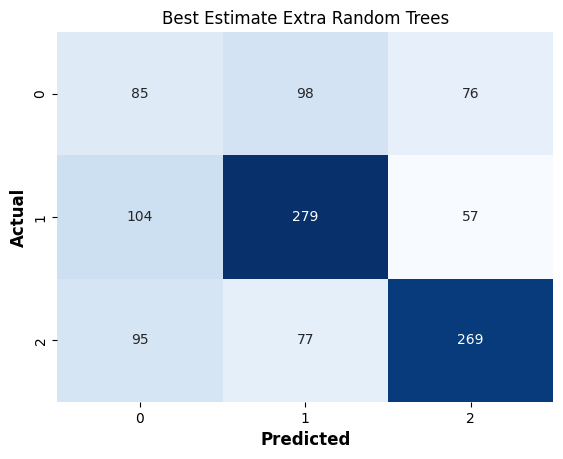

In [136]:
sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimate Extra Random Trees')
plt.show()

## Boosting

In [138]:
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print(classification_report(y_test,y_pred_gb))

              precision    recall  f1-score   support

           0       0.33      0.36      0.34       259
           1       0.66      0.67      0.66       440
           2       0.68      0.63      0.66       441

    accuracy                           0.58      1140
   macro avg       0.56      0.55      0.55      1140
weighted avg       0.59      0.58      0.59      1140



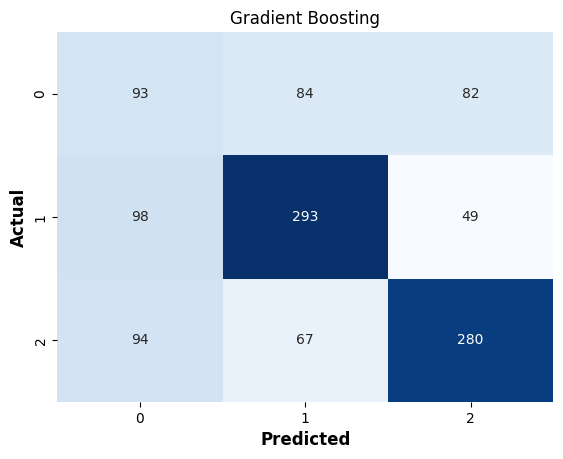

In [140]:
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Gradient Boosting')
plt.show()

In [148]:
param_grid = {
    'learning_rate': [0.1,0.15,0.2,0.25,0.3],
    'loss': ['log_loss', 'exponential'],
    'n_estimators': [10,50,100,200,300,400,500]
}

search = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, scoring = 'f1', cv = 5)
search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
                         'loss': ['log_loss', 'exponential'],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500]},
             scoring='f1')

In [149]:
search.best_params_

{'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 10}

In [150]:
y_pred_gb2 = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_gb2))

              precision    recall  f1-score   support

           0       0.33      0.47      0.39       259
           1       0.67      0.61      0.64       440
           2       0.71      0.59      0.64       441

    accuracy                           0.57      1140
   macro avg       0.57      0.56      0.56      1140
weighted avg       0.61      0.57      0.58      1140



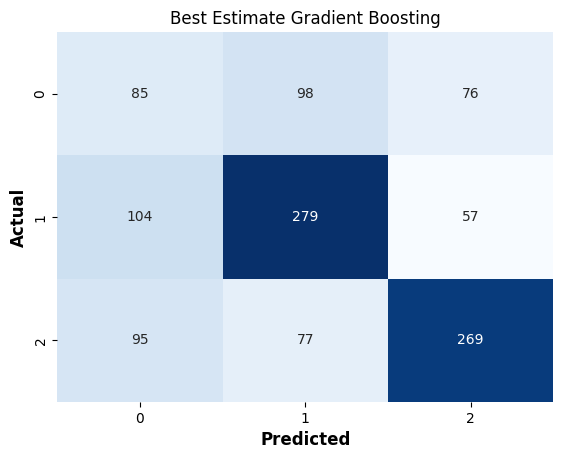

In [151]:
sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Best Estimate Gradient Boosting')
plt.show()

----

# Results

In [159]:
print('Logistic Regression:\n',classification_report(y_test, y_pred_lr2))
print('\nKNearest Neighbors:\n',classification_report(y_test, y_pred_KNN2))
print('\nSupport Vector Machines:\n',classification_report(y_test, y_pred_SVC2))
print('\nRandom Forest:\n',classification_report(y_test, y_pred_RF2))
print('\nExtra Random Trees:\n',classification_report(y_test, y_pred_ETC2))
print('\nBagging:\n',classification_report(y_test, y_pred_bag))
print('\nGradient Boosting:\n',classification_report(y_test, y_pred_gb2))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.31      0.29      0.30       259
           1       0.65      0.67      0.66       440
           2       0.67      0.68      0.67       441

    accuracy                           0.59      1140
   macro avg       0.54      0.55      0.54      1140
weighted avg       0.58      0.59      0.58      1140


KNearest Neighbors:
               precision    recall  f1-score   support

           0       0.26      0.30      0.28       259
           1       0.49      0.52      0.51       440
           2       0.52      0.45      0.48       441

    accuracy                           0.44      1140
   macro avg       0.43      0.42      0.42      1140
weighted avg       0.45      0.44      0.45      1140


Support Vector Machines:
               precision    recall  f1-score   support

           0       0.18      0.02      0.03       259
           1       0.44      0.54      0.48       440
    

From what we can see, the best accuracy show in our `LogisticRegression`, `Random Forest`, `Extra Random Tree` models. However, accuracy is not the only metric that we should look at. Regarding our F1-score and recall, `Random Forest` did the best. For precision, `GradientBoosting` performed the best. If I were to choose one model to use, it would be Random Forest, as it performed the best is majority of the error metrics, and is faster than other models.

A common trend in all of the models was that predicting a draw is harder than predicting a win or a loss. Also, it can be noted that predicting the outcome of a game is a hard task in general.

For improving our model, we could consider adding in more statistics of matches. Also, we could take a look at how long it has been since the teams last game, if the team is using a different formation, if the captain is different, etc. Another approach of improving our model would be to first consider only Win or Loss, then we could try and predict draw. For precision, recall, and f1-score, the draw class never reached over 0.5, which is not good for a model. Trying to optimize winning and losing would be better for prediction.

---